In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [4]:
print("Libraries imported successfully")

Libraries imported successfully


In [5]:
import random

def generate_ph():
    value = round(random.uniform(4.5, 9.5), 2)
    if 6.5 <= value <= 8:
        grade = 'A'
    elif 6 <= value < 6.5 or 8 < value <= 8.9:
        grade = 'B'
    else:
        grade = 'C'
    return value, grade

def generate_tds():
    value = random.randint(50, 1500)
    if 50 <= value <= 500:
        grade = 'A'
    elif 500 < value <= 1000:
        grade = 'B'
    else:
        grade = 'C'
    return value, grade

def generate_turbidity():
    value = round(random.uniform(0, 55), 2)
    if 0 <= value < 5:
        grade = 'A'
    elif 5 <= value <= 15:
        grade = 'B'
    else:
        grade = 'C'
    return value, grade

def calculate_wqi(ph, turbidity, tds):
    ph_score = abs((ph - 7) / 7.5) * 100
    turbidity_score = abs(turbidity / 5) * 100
    tds_score = abs(tds / 500) * 100
    
    # Adjusting weightage based on conditions
    if ph > 8.9 or ph < 6:
        W1, W2, W3 = 0.5, 0.2, 0.3  # Highly Alkaline Water
    elif turbidity > 15:
        W1, W2, W3 = 0.3, 0.5, 0.2  # High Sediment Water
    elif tds > 1000:
        W1, W2, W3 = 0.3, 0.2, 0.5  # Industrial Waste Affected
    else:
        W1, W2, W3 = 0.4, 0.3, 0.3  # Normal Drinking Water
    
    WQI = (W1 * ph_score) + (W2 * turbidity_score) + (W3 * tds_score)
    
    if WQI <= 25:
        wqi_grade = 'A'
    elif 26 <= WQI <= 50:
        wqi_grade = 'B'
    else:
        wqi_grade = 'C'
    
    return round(WQI, 2), wqi_grade

def generate_data(n=1000):
    data = []
    for _ in range(n):
        ph, ph_grade = generate_ph()
        tds, tds_grade = generate_tds()
        turbidity, turbidity_grade = generate_turbidity()
        WQI, wqi_grade = calculate_wqi(ph, turbidity, tds)
        data.append([ph, ph_grade, tds, tds_grade, turbidity, turbidity_grade, WQI, wqi_grade])
    
    df = pd.DataFrame(data, columns=['pH', 'pH Grade', 'TDS', 'TDS Grade', 'Turbidity', 'Turbidity Grade', 'WQI', 'WQI Grade'])
    return df

# Generate dataset
df = generate_data(1000)

# Ensure balance in A, B, C classes for WQI
balanced_df = df.groupby('WQI Grade').apply(lambda x: x.sample(n=300, replace=True)).reset_index(drop=True)

# Save to CSV
balanced_df.to_csv("water_quality_data.csv", index=False)
print("Dataset saved as water_quality_data.csv")

Dataset saved as water_quality_data.csv


In [6]:
df = pd.read_csv("water_quality_data.csv")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Preview:")
display(df.head())

Dataset Shape: (900, 8)

Dataset Preview:


,pH,pH Grade,TDS,TDS Grade,Turbidity,Turbidity Grade,WQI,WQI Grade
0,6.63,A,245,A,0.63,A,20.45,A
1,6.63,A,245,A,0.63,A,20.45,A
2,6.63,A,245,A,0.63,A,20.45,A
3,6.19,B,124,A,0.52,A,14.88,A
4,6.63,A,245,A,0.63,A,20.45,A


In [7]:
print("\nDataset Information:")
display(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               900 non-null    float64
 1   pH Grade         900 non-null    object 
 2   TDS              900 non-null    int64  
 3   TDS Grade        900 non-null    object 
 4   Turbidity        900 non-null    float64
 5   Turbidity Grade  900 non-null    object 
 6   WQI              900 non-null    float64
 7   WQI Grade        900 non-null    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 56.4+ KB


None

In [8]:
print("\nStatistical Summary:")
display(df.describe())


Statistical Summary:


,pH,TDS,Turbidity,WQI
count,900.000000,900.000000,900.000000,900.000000
mean,6.602200,446.220000,10.271411,104.150811
std,1.042426,368.271673,15.332753,135.007153
min,4.500000,52.000000,0.200000,14.880000
25%,6.040000,199.000000,0.630000,21.830000
50%,6.540000,274.000000,2.110000,41.410000
75%,6.962500,578.000000,12.607500,138.410000
max,9.450000,1493.000000,54.690000,595.600000


In [9]:
# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())


Missing Values:


pH                 0
pH Grade           0
TDS                0
TDS Grade          0
Turbidity          0
Turbidity Grade    0
WQI                0
WQI Grade          0
dtype: int64

In [10]:
print("\nWQI Grade Distribution:")
display(df['WQI Grade'].value_counts())


WQI Grade Distribution:


WQI Grade
A    300
B    300
C    300
Name: count, dtype: int64

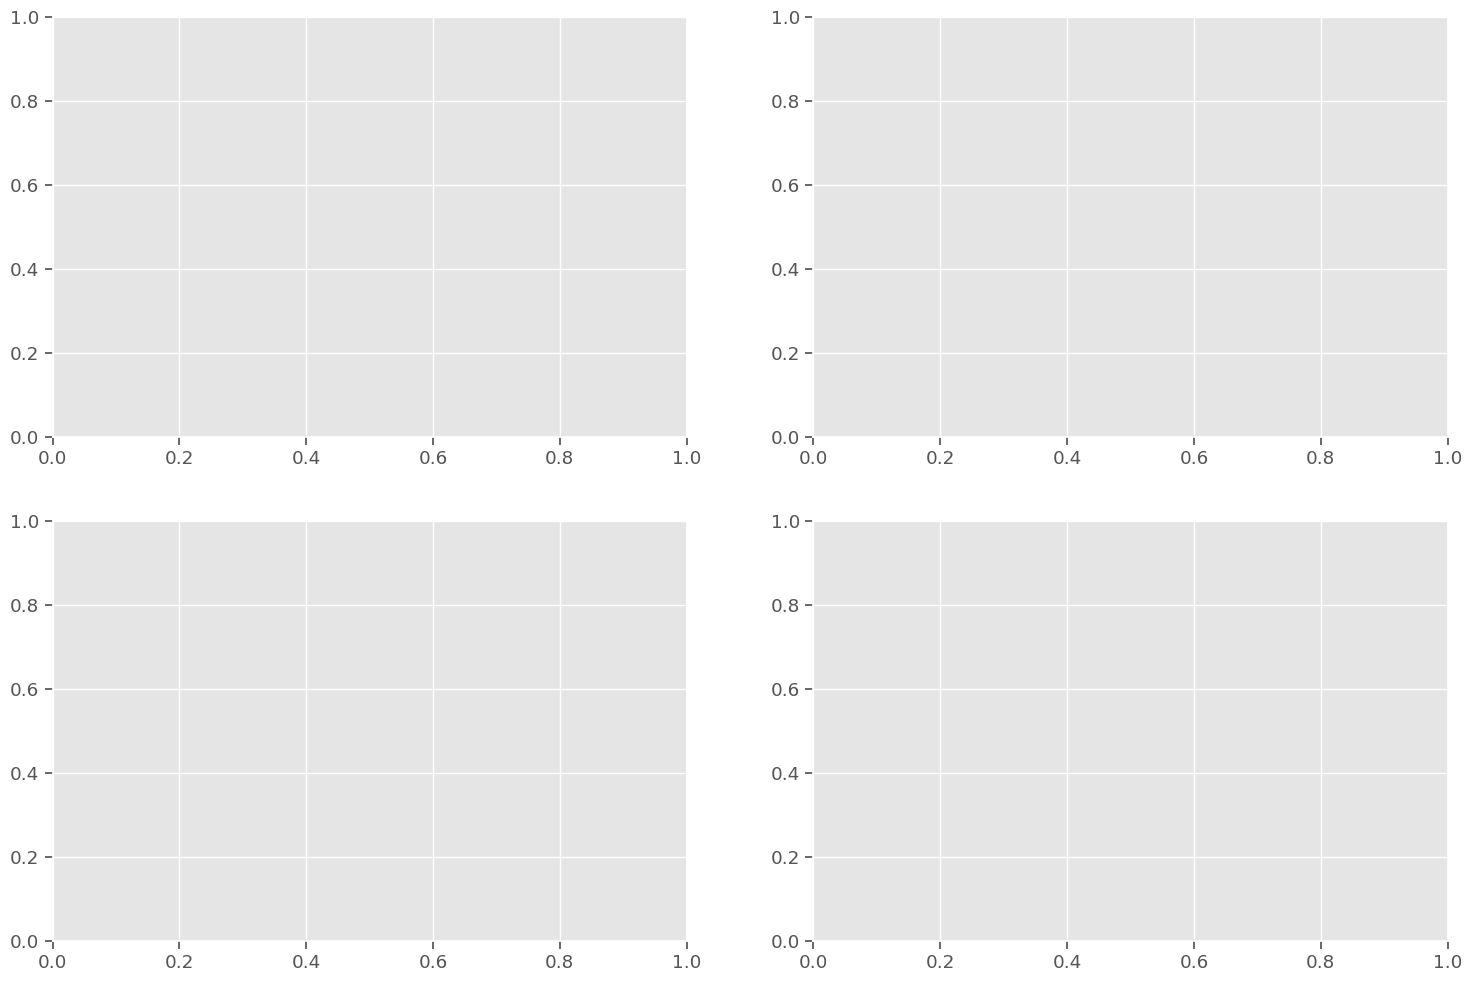

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))


In [12]:
# pH Distribution
sns.histplot(df['pH'], bins=20, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("pH Distribution")
axes[0, 0].axvline(x=6.5, color='r', linestyle='--')
axes[0, 0].axvline(x=8.0, color='r', linestyle='--')
axes[0, 0].text(6.5, axes[0, 0].get_ylim()[1]*0.9, 'Lower Ideal Bound', rotation=90, color='r')
axes[0, 0].text(8.0, axes[0, 0].get_ylim()[1]*0.9, 'Upper Ideal Bound', rotation=90, color='r')

Text(8.0, 230.57999999999998, 'Upper Ideal Bound')

In [13]:
# TDS Distribution
sns.histplot(df['TDS'], bins=20, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title("TDS Distribution")
axes[0, 1].axvline(x=500, color='r', linestyle='--')
axes[0, 1].text(500, axes[0, 1].get_ylim()[1]*0.9, 'Ideal Upper Bound', rotation=90, color='r')

Text(500, 179.55, 'Ideal Upper Bound')

In [14]:
# Turbidity Distribution
sns.histplot(df['Turbidity'], bins=20, kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title("Turbidity Distribution")
axes[1, 0].axvline(x=5, color='r', linestyle='--')
axes[1, 0].text(5, axes[1, 0].get_ylim()[1]*0.9, 'Ideal Upper Bound', rotation=90, color='r')

Text(5, 466.83000000000004, 'Ideal Upper Bound')

In [15]:
# WQI Distribution
sns.histplot(df['WQI'], bins=20, kde=True, ax=axes[1, 1], color='orange')
axes[1, 1].set_title("WQI Distribution")
axes[1, 1].axvline(x=25, color='r', linestyle='--')
axes[1, 1].axvline(x=50, color='r', linestyle='--')
axes[1, 1].text(25, axes[1, 1].get_ylim()[1]*0.9, 'A-B Boundary', rotation=90, color='r')
axes[1, 1].text(50, axes[1, 1].get_ylim()[1]*0.9, 'B-C Boundary', rotation=90, color='r')

Text(50, 430.92, 'B-C Boundary')

In [16]:

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'pH Grade Distribution')

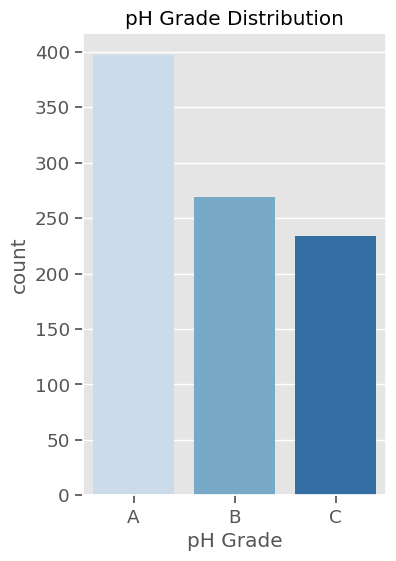

In [17]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
sns.countplot(x='pH Grade', data=df, palette='Blues')
plt.title('pH Grade Distribution')

Text(0.5, 1.0, 'TDS Grade Distribution')

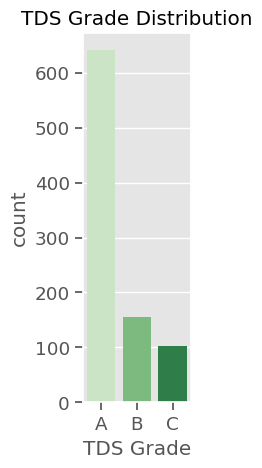

In [18]:

plt.subplot(1, 4, 2)
sns.countplot(x='TDS Grade', data=df, palette='Greens')
plt.title('TDS Grade Distribution')

Text(0.5, 1.0, 'Turbidity Grade Distribution')

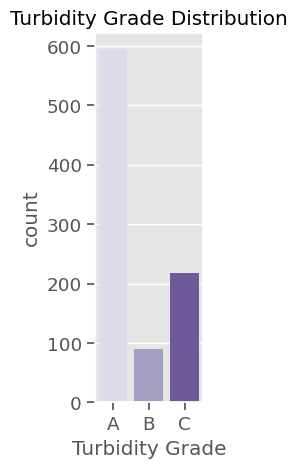

In [19]:
plt.subplot(1, 4, 3)
sns.countplot(x='Turbidity Grade', data=df, palette='Purples')
plt.title('Turbidity Grade Distribution')

Text(0.5, 1.0, 'WQI Grade Distribution')

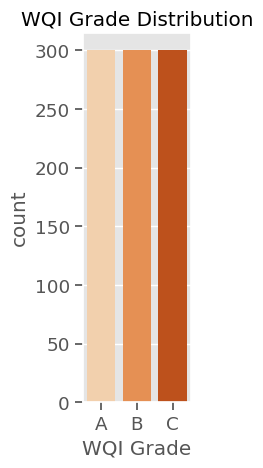

In [20]:

plt.subplot(1, 4, 4)
sns.countplot(x='WQI Grade', data=df, palette='Oranges')
plt.title('WQI Grade Distribution')


<Figure size 640x480 with 0 Axes>

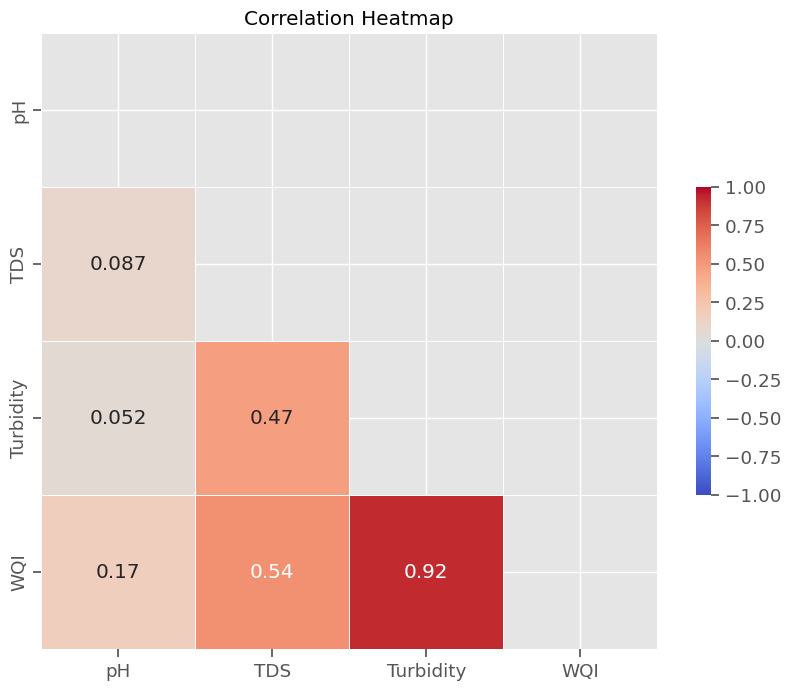

In [21]:
plt.tight_layout()
plt.show()

# Cell 6: Exploratory Data Analysis - Correlation Analysis
# Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()


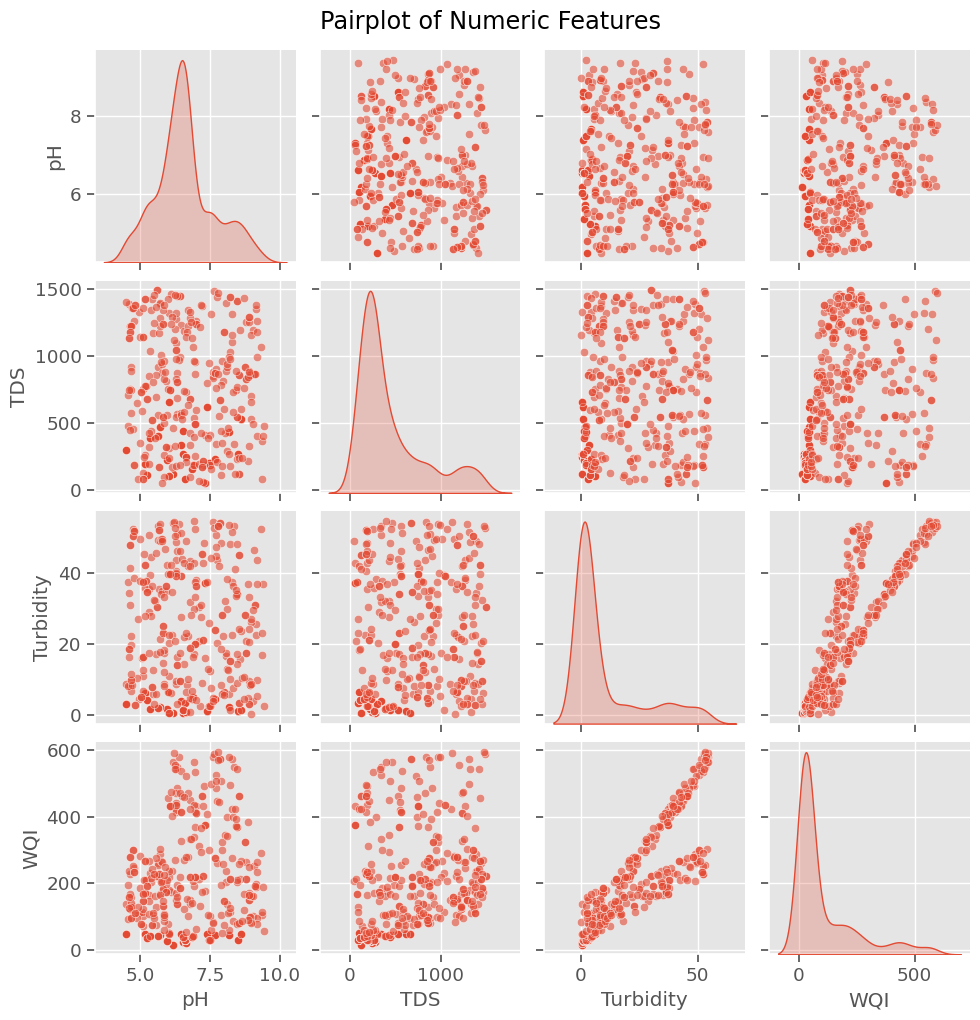

In [22]:
sns.pairplot(numeric_df, height=2.5, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

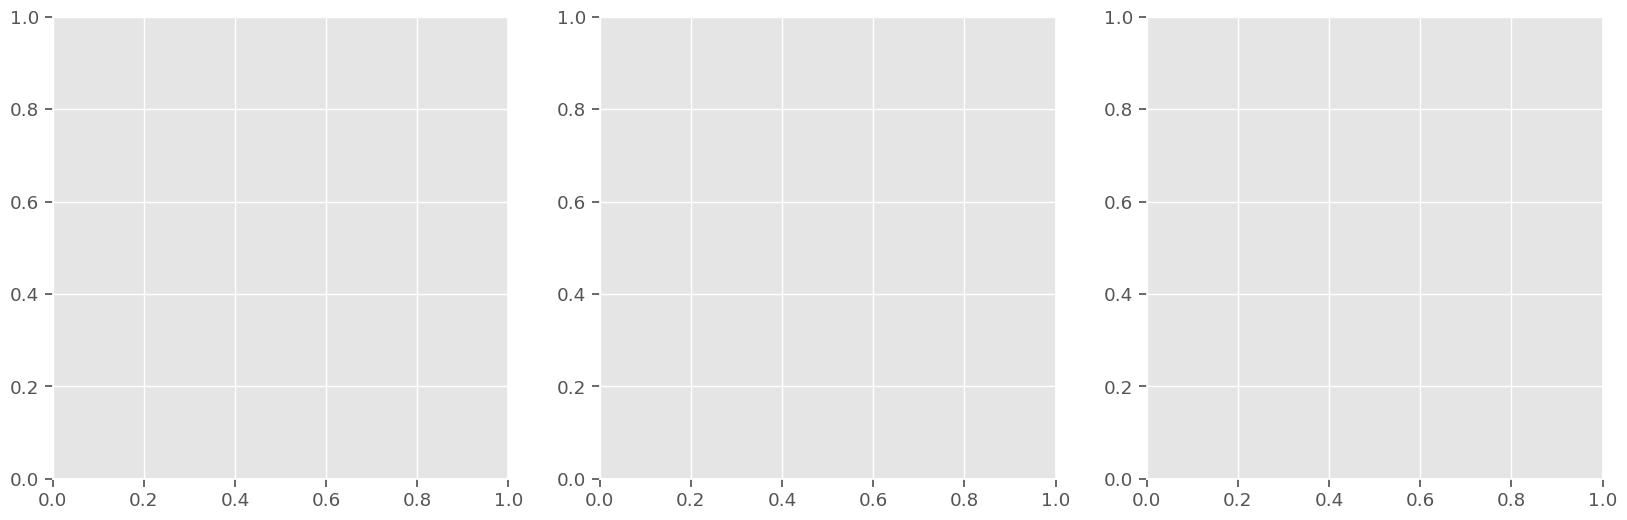

In [23]:
# Cell 7: Exploratory Data Analysis - Bivariate Analysis
fig, axes = plt.subplots(1, 3, figsize=(20, 6))


In [24]:
sns.scatterplot(x='pH', y='WQI', data=df, hue='WQI Grade', palette='viridis', alpha=0.7, ax=axes[0])
axes[0].set_title('pH vs WQI')
axes[0].axvline(x=6.5, color='gray', linestyle='--')
axes[0].axvline(x=8.0, color='gray', linestyle='--')
axes[0].axhline(y=25, color='gray', linestyle='--')
axes[0].axhline(y=50, color='gray', linestyle='--')


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
colors = sns.color_palette("viridis", 4)

print("Libraries imported successfully")

# Cell 2: Load Dataset and Calculate Actual WQI
# Load the actual dataset
df = pd.read_csv("D:\\Clean_Green\\Dataset.csv")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Preview:")
display(df.head())

# Define WQI calculation function based on provided logic
def calculate_wqi(ph, turbidity, tds):
    ph_score = abs((ph - 7) / 7.5) * 100
    turbidity_score = abs(turbidity / 5) * 100
    tds_score = abs(tds / 500) * 100
    
    # Adjusting weightage based on conditions
    if ph > 8.9 or ph < 6:
        W1, W2, W3 = 0.5, 0.2, 0.3  # Highly Alkaline Water
    elif turbidity > 15:
        W1, W2, W3 = 0.3, 0.5, 0.2  # High Sediment Water
    elif tds > 1000:
        W1, W2, W3 = 0.3, 0.2, 0.5  # Industrial Waste Affected
    else:
        W1, W2, W3 = 0.4, 0.3, 0.3  # Normal Drinking Water
    
    WQI = (W1 * ph_score) + (W2 * turbidity_score) + (W3 * tds_score)
    
    if WQI <= 25:
        wqi_grade = 'A'
    elif 26 <= WQI <= 50:
        wqi_grade = 'B'
    else:
        wqi_grade = 'C'
    
    return round(WQI, 2), wqi_grade

# Verify WQI calculation against dataset values
# If WQI is already correctly calculated in dataset, this is validation
# If not, this adds/corrects the WQI values
calculated_wqi = []
calculated_grades = []

for _, row in df.iterrows():
    wqi, grade = calculate_wqi(row['pH'], row['Turbidity'], row['TDS'])
    calculated_wqi.append(wqi)
    calculated_grades.append(grade)

df['Calculated_WQI'] = calculated_wqi
df['Calculated_Grade'] = calculated_grades

# Check if calculated values match original values
if 'WQI' in df.columns:
    wqi_diff = np.abs(df['WQI'] - df['Calculated_WQI']).mean()
    print(f"\nAverage difference between dataset WQI and calculated WQI: {wqi_diff:.4f}")
    
    # If significant difference, we'll use calculated values
    if wqi_diff > 0.1:
        print("Using calculated WQI values for consistency with the provided formula")
        df['WQI'] = df['Calculated_WQI']
        if 'WQI Grade' in df.columns:
            df['WQI Grade'] = df['Calculated_Grade']
    else:
        print("Dataset WQI values match calculated values")
else:
    # If WQI not in original data, use calculated values
    print("Adding calculated WQI values to dataset")
    df['WQI'] = df['Calculated_WQI']
    df['WQI Grade'] = df['Calculated_Grade']

# Drop temporary columns
df = df.drop(['Calculated_WQI', 'Calculated_Grade'], axis=1, errors='ignore')

# Display updated dataset
print("\nUpdated Dataset with verified WQI values:")
display(df.head())


Libraries imported successfully
Dataset Shape: (900, 5)

Dataset Preview:


,pH,TDS,Turbidity,WQI,WQI Grade
0,6.73,185,0.22,13.86,A
1,7.52,208,1.37,23.47,A
2,6.80,140,2.25,22.97,A
3,6.80,140,2.25,22.97,A
4,7.52,208,1.37,23.47,A



Average difference between dataset WQI and calculated WQI: 0.0000
Dataset WQI values match calculated values

Updated Dataset with verified WQI values:


,pH,TDS,Turbidity,WQI,WQI Grade
0,6.73,185,0.22,13.86,A
1,7.52,208,1.37,23.47,A
2,6.80,140,2.25,22.97,A
3,6.80,140,2.25,22.97,A
4,7.52,208,1.37,23.47,A


SyntaxError: invalid syntax (1448290855.py, line 1)